In [47]:
# Plot Percentage Loss over Influence Index
import matplotlib.pyplot as plt
import numpy as np
from results import report

ADVERSARIAL_ATTACK = 'to_src'
for graph_type, graph_type_data in report.items():
    temp = graph_type_data.copy().items()
    for window, window_data in temp:
        temp2 = window_data.copy().items()
        for attack, attack_data in temp2:
            if attack_data['support'] < 1000:
                del report[graph_type][window][attack]
        

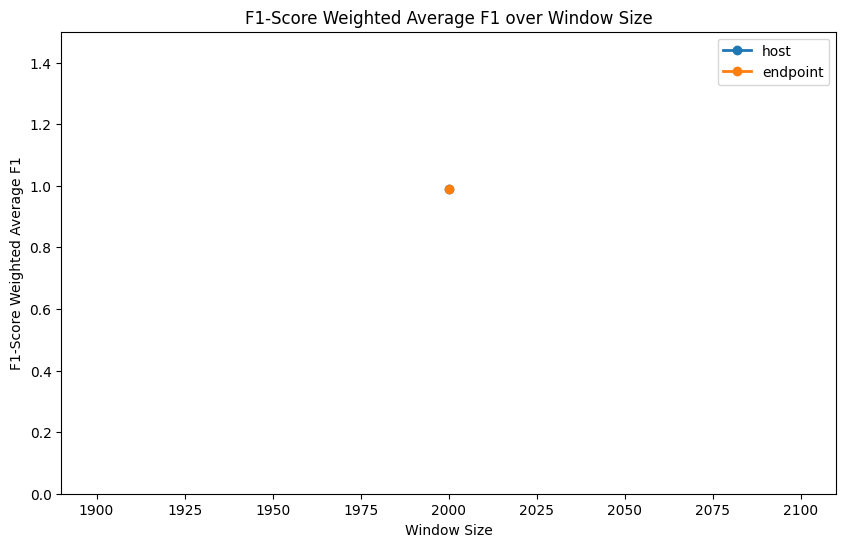

In [48]:
def plot_normal_f1_over_window(report):
    plt.figure(figsize=(10, 6))
    for graph_type, graph_type_data in report.items():
        window_sizes = []
        losses = []
        for window_size, attacks in graph_type_data.items():
            if 'Weighted Average' in attacks:
                window_sizes.append(window_size)
                class_data = attacks['Weighted Average']
                losses.append(class_data['normal_f1'])
        plt.plot(window_sizes, losses, label=graph_type, marker='o', linewidth=2)

    plt.xlabel('Window Size')
    plt.ylabel('F1-Score Weighted Average F1')
    plt.title('F1-Score Weighted Average F1 over Window Size')
    plt.ylim(0, 1.5)
    plt.legend()
    plt.show()

plot_normal_f1_over_window(report)

In [49]:
def get_percentage_loss(class_data):
    """Calculate the percentage loss."""
    normal_f1 = class_data['normal_f1']
    adversarial_f1 = class_data[f'{ADVERSARIAL_ATTACK}_f1']
                
    epsilon = 1e-10  # To avoid division by zero
    return (normal_f1 - adversarial_f1) / (normal_f1 + epsilon) * 100

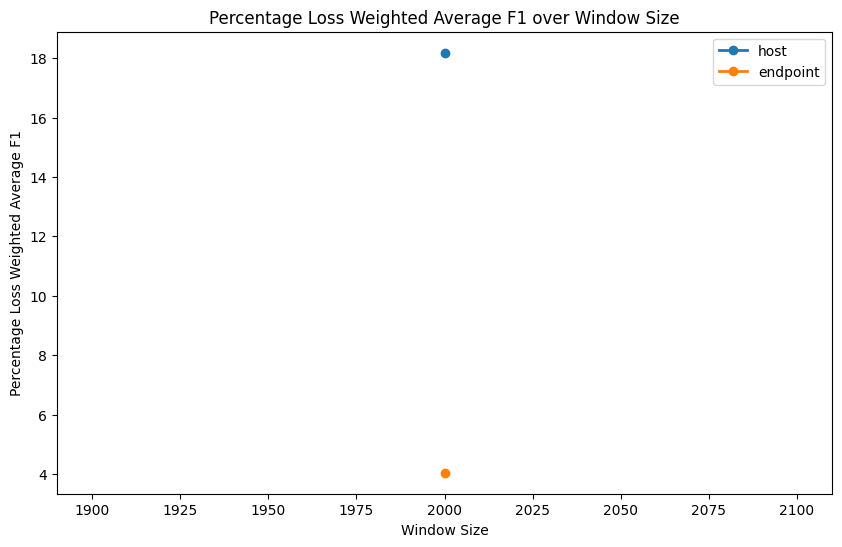

In [50]:
def plot_weighted_average_over_window(report):
    plt.figure(figsize=(10, 6))
    for graph_type, graph_type_data in report.items():
        window_sizes = []
        losses = []
        for window_size, attacks in graph_type_data.items():
            if 'Weighted Average' in attacks:
                window_sizes.append(window_size)
                class_data = attacks['Weighted Average']
                losses.append(get_percentage_loss(class_data))
        plt.plot(window_sizes, losses, label=graph_type, marker='o', linewidth=2)

    plt.xlabel('Window Size')
    plt.ylabel('Percentage Loss Weighted Average F1')
    plt.title('Percentage Loss Weighted Average F1 over Window Size')
    plt.legend()
    plt.show()

plot_weighted_average_over_window(report)

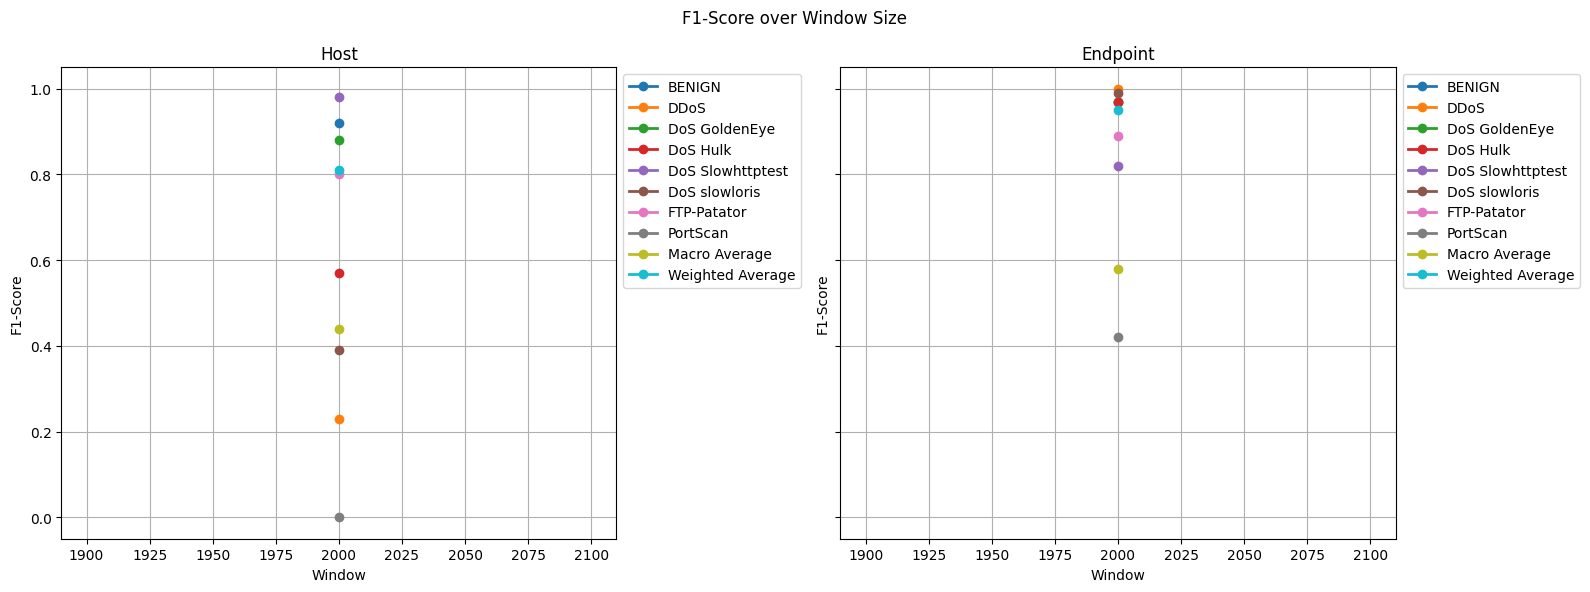

In [51]:
def plot_f1_over_window(report):
    fig, axes = plt.subplots(1, len(report), figsize=(16, 6), sharey=True)

    if len(report) == 1:
        axes = [axes]

    for ax, (host_type, data) in zip(axes, report.items()):
        # Prepare data grouped by attack_name
        grouped_data = {}
        for window_size, attacks in data.items():
            for attack_name, attack_data in attacks.items():
                adversarial_f1 = attack_data[f"{ADVERSARIAL_ATTACK}_f1"]
                if attack_name not in grouped_data:
                    grouped_data[attack_name] = {"window_size": [], f"{ADVERSARIAL_ATTACK}_f1": []}
                grouped_data[attack_name]["window_size"].append(window_size)
                grouped_data[attack_name][f"{ADVERSARIAL_ATTACK}_f1"].append(adversarial_f1)

        # Plot grouped data
        for attack_name, vals in grouped_data.items():
            ax.plot(vals["window_size"], vals[f"{ADVERSARIAL_ATTACK}_f1"], label=attack_name, marker='o', linewidth=2)

        ax.set_title(f'{host_type.capitalize()}')
        ax.set_xlabel('Window')
        ax.set_ylabel('F1-Score')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    fig.suptitle('F1-Score over Window Size')
    plt.tight_layout()
    plt.show()

plot_f1_over_window(report)

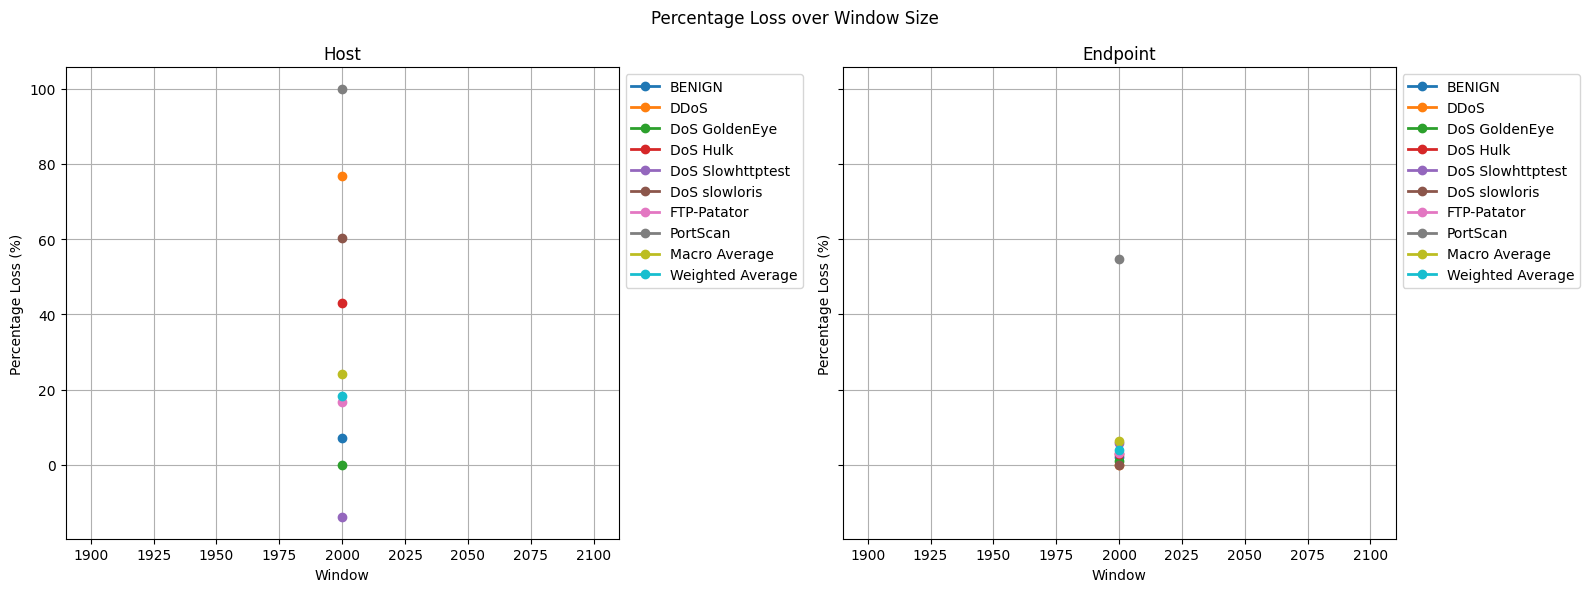

In [52]:
def plot_percentage_loss_over_window(report):
    fig, axes = plt.subplots(1, len(report), figsize=(16, 6), sharey=True)

    if len(report) == 1:
        axes = [axes]

    for ax, (host_type, data) in zip(axes, report.items()):
        # Prepare data grouped by attack_name
        grouped_data = {}
        for window_size, attacks in data.items():
            for attack_name, attack_data in attacks.items():
                
                adversarial_percentage_loss = get_percentage_loss(attack_data)
                if attack_name not in grouped_data:
                    grouped_data[attack_name] = {"window_size": [], f"{ADVERSARIAL_ATTACK}_percentage_loss": []}
                grouped_data[attack_name]["window_size"].append(window_size)
                grouped_data[attack_name][f"{ADVERSARIAL_ATTACK}_percentage_loss"].append(adversarial_percentage_loss)

        # Plot grouped data
        for attack_name, vals in grouped_data.items():
            ax.plot(vals["window_size"], vals[f"{ADVERSARIAL_ATTACK}_percentage_loss"], label=attack_name, marker='o', linewidth=2)

        ax.set_title(f'{host_type.capitalize()}')
        ax.set_xlabel('Window')
        ax.set_ylabel('Percentage Loss (%)')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    fig.suptitle('Percentage Loss over Window Size')
    plt.tight_layout()
    plt.show()

plot_percentage_loss_over_window(report)

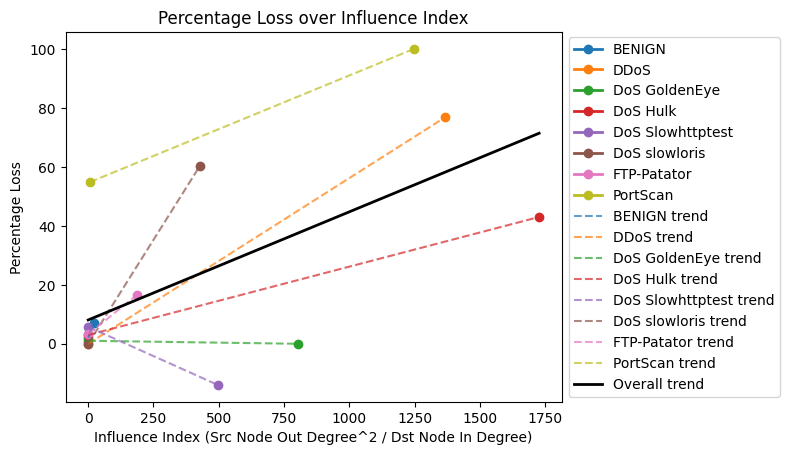

In [56]:
def plot_percentage_loss_over_influence(report):
    color_map = {}
    color_cycle = plt.cm.tab10.colors  # 10 distinct colors
    class_names = set()
    # Collect all unique class names
    for graph_type_data in report.values():
        for window_data in graph_type_data.values():
            class_names.update(window_data.keys())
    # Assign a color to each class name
    for idx, class_name in enumerate(sorted(class_names)):
        color_map[class_name] = color_cycle[idx % len(color_cycle)]

    influence_indices = []
    percentage_losses = []
    class_points = {}

    for graph_type_id, graph_type_data in report.items():
        for window, window_data in graph_type_data.items():
            for class_name, data in window_data.items():
                if class_name == 'Weighted Average' or class_name == 'Macro Average':
                    continue
                min_out_degree, avg_out_degree, max_out_degree = data['out_degree']
                min_in_degree, avg_in_degree, max_in_degree = data['in_degree']
                avg_index = avg_out_degree ** 2 / avg_in_degree
                percentage_loss = get_percentage_loss(data)
                influence_indices.append(avg_index)
                percentage_losses.append(percentage_loss)
                if class_name not in class_points:
                    class_points[class_name] = {"x": [], "y": []}
                class_points[class_name]["x"].append(avg_index)
                class_points[class_name]["y"].append(percentage_loss)
                plt.plot(
                    [avg_index], 
                    [percentage_loss], 
                    marker='o', 
                    label=f'{class_name}', 
                    linewidth=2,
                    color=color_map[class_name]
                )

    # Plot trendline per class
    for class_name, points in class_points.items():
        if len(points["x"]) > 1:
            z = np.polyfit(points["x"], points["y"], 1)
            p = np.poly1d(z)
            x_vals = np.linspace(min(points["x"]), max(points["x"]), 100)
            plt.plot(x_vals, p(x_vals), "--", color=color_map[class_name], alpha=0.7, label=f"{class_name} trend")

    # Fit and plot the overall trend line
    if len(influence_indices) > 1:
        z = np.polyfit(influence_indices, percentage_losses, 1)
        p = np.poly1d(z)
        x_vals = np.linspace(min(influence_indices), max(influence_indices), 100)
        plt.plot(x_vals, p(x_vals), "k-", label="Overall trend", linewidth=2)

    plt.xlabel('Influence Index (Src Node Out Degree^2 / Dst Node In Degree)')
    plt.ylabel('Percentage Loss')
    plt.title('Percentage Loss over Influence Index')
    # Only show unique labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_percentage_loss_over_influence(report)